In [1]:
import os.path
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib
import matplotlib.pyplot as plt # this is used for the plot the graph 
from matplotlib import patches
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.cross_validation import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score
from scipy.signal import argrelextrema, resample

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential, model_from_json
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

# time series
from datetime import datetime, timedelta

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


### Plotting params

In [2]:
sns.set(style="whitegrid") # set seaborn for pretty plots
#plt.rc('legend', fontsize=12) # legend fontsize

### Data munging functions
A bunch of helpers

In [3]:
# Renames columns to standard format listed above,
# Normalizes timestamps relative to 0 (instead of experiment start time),
# Fills NaNs, inverts force.
def clean(df):
    df.columns = ["f", "mdia", "msgtype", "pwm", "rc", "rw", "t", "t0", "timestamp"]
    if(df.iloc[0].timestamp > 0):
        df.timestamp -= df.iloc[0].timestamp
    df.pwm.replace(to_replace=0, value=np.NaN, inplace=True)
    df.f = -df.f
    return df.fillna(0)

In [4]:
# Grabs rolling average with default lag of 300-points.
# You can set #points in rolling window with `window` param, and
# select whether to add the rolling average column to the given 
# dataframe with `add_col` param.
def ma(df, window=500, add_col=True):
    m = df.f.rolling(window=window).mean()
    if add_col:
        df['f_ra'] = m
        return df.fillna(0)
    return m

In [5]:
# Grabs minima and maxima.
# This is its own function only because this is an expensive operation.
# Note this function operates on the rolling average, not the raw force, to prevent noisy points from interfering.
def get_extrema(df, order=2000, ra=False):
    col = 'f_ra' if ra else 'f'
    maxima = argrelextrema(df[col].values, np.greater, order=order)
    minima = argrelextrema(df[col].values, np.less, order=order)
    return minima, maxima

In [6]:
# Labels cycles based on local (force) minima and maxima.
# Points not belonging to a valid cycle, e.g. at start and end of experiment,
# are labeled with <cycle# = -1>.
def label_cycles(df, minima, maxima, ax=None, abs_min=None, abs_max=None, plot_boxes=True):
    # Plot line connecting all minima, and another line connecting all maxima.
    if not ax:
        fig, ax = plt.subplots(figsize=(25, 6), nrows=1, ncols=1)
    if abs_min and abs_max:
        ax.plot(df.f, alpha=0.3)
        ax.plot(df.f.iloc[abs_max[0].tolist()], '--')
        ax.plot(df.f.iloc[abs_min[0].tolist()], '--')

    # Label cycles.
    df['cycle'] = -1
    for i in range(minima[0].size-1):
        rng = list(range(minima[0][i], minima[0][i+1]))
        df.iloc[rng, df.columns.get_loc('cycle')] = i # I don't know why `iloc` succeeds while `loc` fails here. I spent 1.5 hours on this bug.
  
    # Draw bounding boxes around each cycle.
    if plot_boxes:
        for i in minima[0].tolist():
            ax.add_patch(
                patches.Rectangle((i, df.f.min()), df[df.cycle==i].shape[0], df.f.max()-df.f.min(), linewidth=1, edgecolor='black', facecolor='none', alpha=0.2, linestyle=':')
            )
    df.cycle = df.cycle.astype(np.int64) # Just to be safe
    return df

In [7]:
# Squashes periods down to a constant for all rows in a dataset.
# You can set the desired period with param `period`.
# If you don't, the function just chooses the shortest period.
def squash_periods(df, period=-1, plot_cycles=True):
    #ss.reset_orig()
    c_to_p = {} # maps cycles to their periods
    columns=["f", "pwm", "t", "t0", "f_ra", "cycle", "timestamp"]
    fig, ax = plt.subplots(figsize=(25, 12), nrows=1, ncols=1)
    df.cycle, X = df.cycle.astype(np.int64), pd.DataFrame(columns=columns)
        
    for c in range(df.cycle.max()):
        c_to_p[c] = df[df.cycle==c].shape[0]
    if period<0:
        period = int(min(c_to_p.values()))

    if not os.path.isfile('temp.pkl'):
        for c in range(df.cycle.max()):
            C = pd.DataFrame(resample(df[df.cycle==c], period), columns=columns)
            C.cycle = c
            X = pd.concat([X, C], ignore_index=True)
            if plot_cycles:
                ax.plot(C.f_ra, color=plt.cm.RdYlBu(float(c)/df.cycle.max()))
        X.timestamp = df.timestamp.iloc[:X.timestamp.size,]
        X.to_pickle('temp.pkl')
    else:
        from scipy.signal import savgol_filter
        lastmax = 0
        X = pd.read_pickle('temp.pkl')
        for c in range(X.cycle.max()):
            C = pd.DataFrame(resample(df[df.cycle==c], period), columns=columns)
            C.cycle = c
            #print C.f_ra.min(), C.f_ra.max()
            
            yhat = savgol_filter(C.f, 101, 3)
            ax.plot(yhat, color=plt.cm.RdYlBu(float(c)/X.cycle.max()))
            #lastmax = C.f_ra.max()
    
    if plot_cycles:
        cmap = plt.cm.ScalarMappable(
            norm=matplotlib.colors.Normalize(vmin=0, vmax=df.cycle.max()),
            cmap=plt.get_cmap('RdYlBu', df.cycle.max())
        )
        cmap.set_array([])
        plt.colorbar(cmap, orientation="horizontal", pad=0.1)
    plt.show()

    return X, c_to_p

### Run data munging

In [ ]:
# X_100 is a dataset with estimated 100 cycles and conductive paste in silicon skin.
X100 = ma(clean(pd.DataFrame.from_dict(
    pd.read_msgpack("data/data_2018-11-16-21-07-24.msgpack"))), window=150)
X100.drop(columns=['mdia', 'msgtype', 'rc', 'rw'], inplace=True) # clean up unnecessary columns

In [8]:
X61 = ma(clean(pd.DataFrame.from_dict(
    pd.read_msgpack("data/data_2018-12-12-18-21-34.msgpack"))), window=150)
X61.drop(columns=['mdia', 'msgtype', 'rc', 'rw'], inplace=True) # clean up unnecessary columns

In [ ]:
def plot_raw(df, n_cycles=103):
    # one figure / two charts
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(30, 15))
    fig.suptitle('Raw measurements, %d cycles' % 103)

    # top chart
    ax.flat[0].plot(df.f, alpha=0.8, label='Force'); ax2 = ax.flat[0].twinx()
    ax2.plot(df.pwm, c='r', alpha=0.3, label='PWM')
    ax.flat[0].legend(bbox_to_anchor=(0.957,0.45)); ax2.legend(bbox_to_anchor=(1,0.5))

    # bottom chart
    ax.flat[1].plot(df.t, label='Absolute temperature (C)'); ax.flat[1].plot(df.t-df.t0, label='Muscle temperature (C)')
    ax.flat[1].legend()
    plt.show()

In [ ]:
plot_raw(X100, n_cycles=103)
plot_raw(X61, n_cycles=61)

### Force-temperature correlation
Joint probabilities / Pearson correlation let us know whether a temperature-force relationship is worth investigating

In [9]:
def pickle_meta(df, name='df'):
    filename = 'meta_%s.pkl' % name
    # pickle data, if not already done so
    if not os.path.isfile(filename):
        minima, maxima = get_extrema(df, ra=True)
        abs_min, abs_max = get_extrema(df, order=3000, ra=False)
        df = label_cycles(df, minima, maxima, abs_min=abs_min, abs_max=abs_max)
        df.cycle = df.cycle.astype(np.int64)
        df_s, c_to_p = squash_periods(df)
        df_s.cycle = df_s.cycle.astype(np.int64)
        df.to_pickle(filename)
        df_s.to_pickle('meta_%sS.pkl' % name)

In [10]:
def ft_corr(df, df_s):
    if type(df.timestamp.iloc[0,]) != pd._libs.tslibs.timestamps.Timestamp: # convert to datetime timestamp, if necessary
        df.timestamp = df.timestamp.map(lambda t: datetime.fromtimestamp(t));
        df = df.set_index(pd.DatetimeIndex(df.timestamp), inplace=False);
    df_s.set_index(pd.DatetimeIndex(df_s.timestamp.map(lambda t: datetime.fromtimestamp(t))), inplace=True);
    season = int((df_s[df_s.cycle==1].shape[0])/0.1) #ms
    sns.jointplot(x=df_s.resample('%dL' % season).mean().t,\
              y=df_s.resample('%dL' % season).mean().f_ra, ratio=10)
    plt.show()
    return df, df_s

### 61-cycles normalized
Periods normalized to fixed $\Delta t$ using FFT.

In [11]:
RESET = False
if not os.path.isfile('d2.temp.pkl') or RESET:
    d2 = X61.copy()
    minima, maxima = get_extrema(d2, ra=True)
    abs_min, abs_max = get_extrema(d2, order=1500, ra=False)
    d2 = label_cycles(d2, minima, maxima, abs_min=abs_min, abs_max=abs_max)
    d2.cycle = d2.cycle.astype(np.int64)
    d2.to_pickle('d2.temp.pkl')

/usr/local/lib/python2.7/dist-packages/scipy/signal/signaltools.py:2205: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/usr/local/lib/python2.7/dist-packages/scipy/signal/signaltools.py:2207: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/usr/local/lib/python2.7/dist-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq

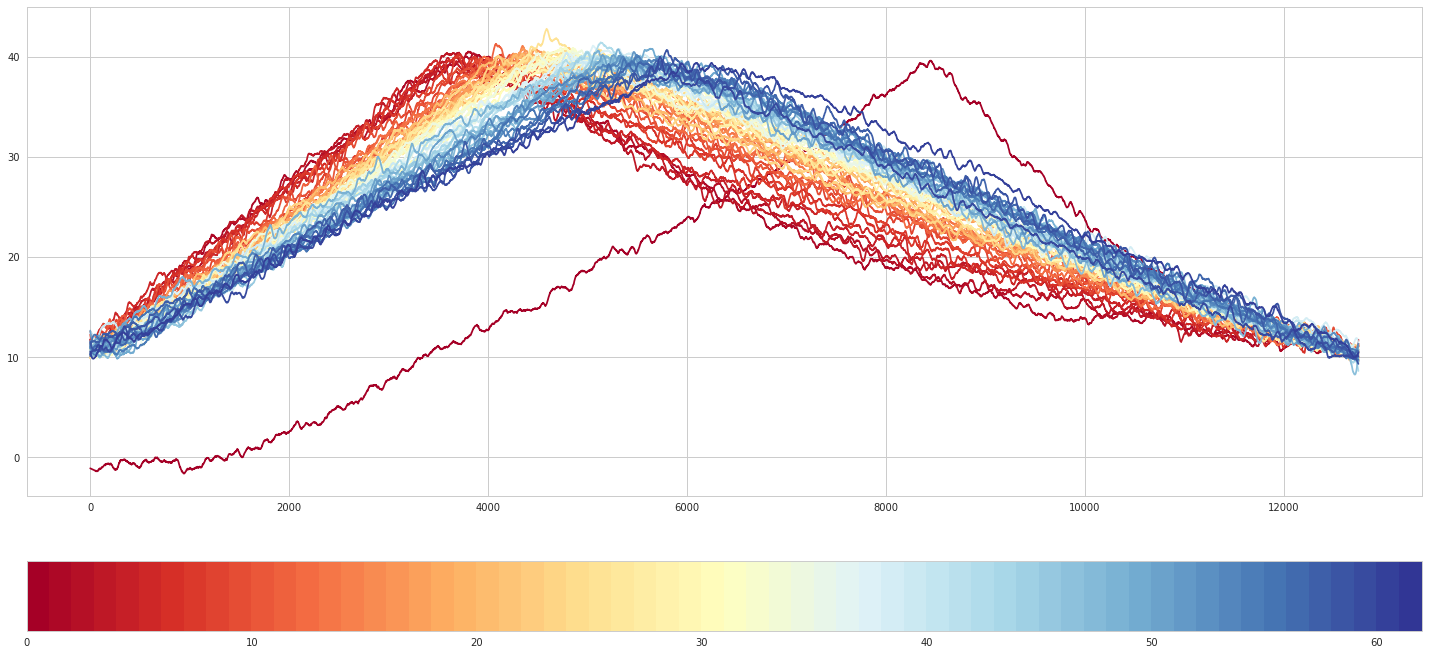

In [12]:
d2 = pd.read_pickle('d2.temp.pkl')
d2.cycle = d2.cycle.astype(np.int64)
d2_s, c_to_p = squash_periods(d2)

In [9]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]

### Autocorrelation
Measures the correlation of a cycle $c_i$ with cycle $c_{i-1}, c_{i-2}, \dots, c_1$. Here correlation $\rho$ is
$$
\rho_{i,j} = \frac{\mathbb{E}\Big[\big(X_{c_i}-\mu_{c_i}\big)\big(X_{c_j}-\mu_{c_j}\big)\Big]}{\sigma_{c_i}\sigma_{c_{j}}}
$$
and, for $n$ cycles, autocorrelation is equivalent to
$$
\rho_{i,j} \quad (i,j) \in (0,\dots,n)
$$

Raw temperature `t` autocorrelation:

In [37]:
zt = autocorr(X61.t)

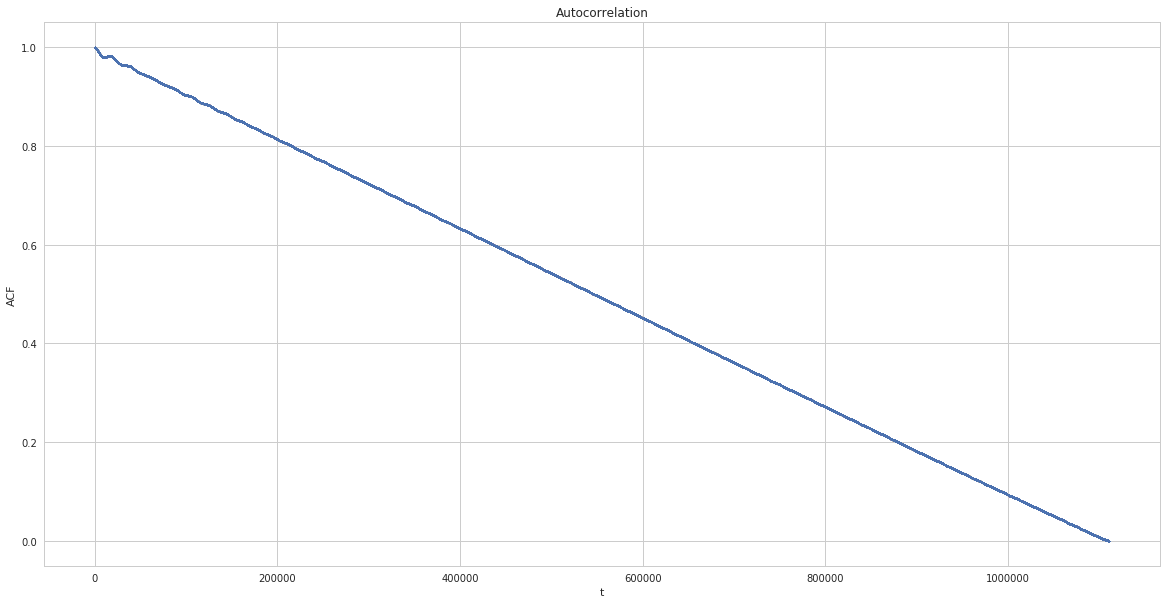

In [38]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(np.arange(zt.shape[0]), zt / float(zt.max()), s=0.5)
ax.set_title('Autocorrelation')
ax.set_xlabel('t')
ax.set_ylabel('ACF')
plt.show()

Force autocorrelation (raw force `f`):

The autocorrelation is almost linear, suggesting strong correlation between a cycle and its recent lagged cycles.  
This plot suggests that any given (force) observation is highly correlated with the most recent $1$ to $9$ cycles. Thus a time-series model predicting force observations given previous cycles' force observations is reasonable, and an LSTM model may be appropriate.

In [10]:
z = autocorr(X61.f)

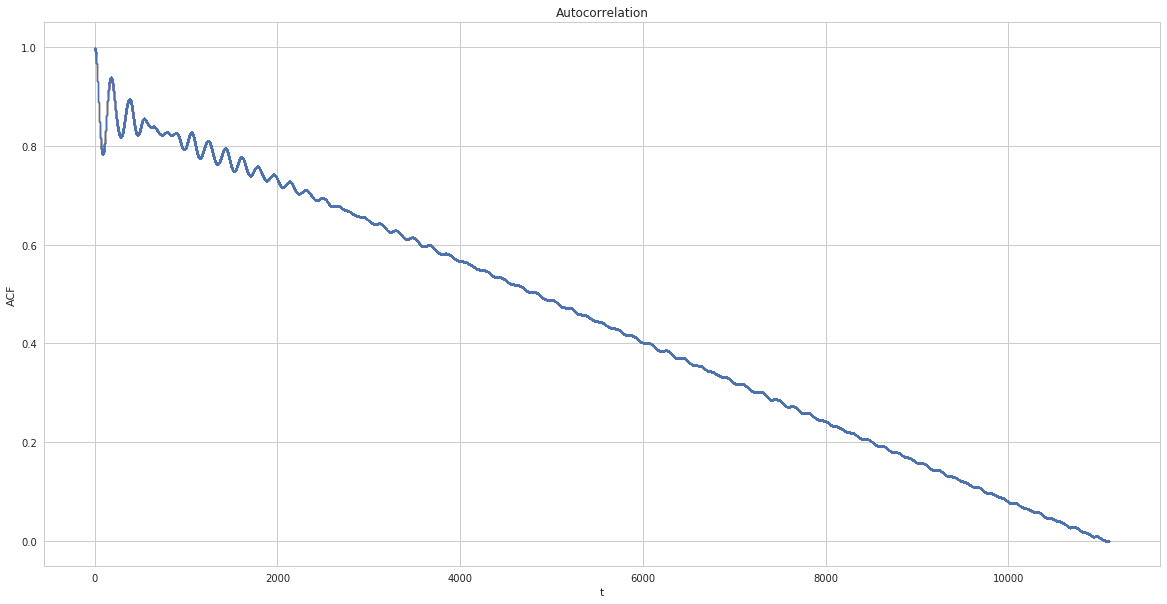

In [36]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(np.arange(z.shape[0])/100, z / float(z.max()), s=0.5)
ax.set_title('Autocorrelation')
ax.set_xlabel('t')
ax.set_ylabel('ACF')
plt.show()

In [ ]:
pickle_meta(X100, name='X100')
pickle_meta(X61, name='X61')

## Joint plots
We smooth force using a simple rolling average over a 1500ms time window:
$$
f_{ra} = \frac{f_{t_i-1500ms} + \dots + f_{t_i}}{n}
$$
where $n=150$ is the number of samples collected from time $t_i-1500ms$ to time $t_i$. The joint probability of smoothed force observations against temperature are pictured below. With Pearson's $\rho=0.95$ and $\rho=0.81$ we conclude that smoothed force and temperature are strongly correlated ($p<<1$). Thus we attempt to model force in response to temperature, timestamp, PWM, and previous force factors.

In [ ]:
unpickled_df, unpickled_df_s = pd.read_pickle('meta_X100.pkl'), pd.read_pickle('meta_X100S.pkl')
X100, X100S = ft_corr(unpickled_df, unpickled_df_s)

In [ ]:
unpickled_df, unpickled_df_s = pd.read_pickle('meta_X61.pkl'), pd.read_pickle('meta_X61S.pkl')
X61, X61S = ft_corr(unpickled_df, unpickled_df_s)

### Train-test split

In [ ]:
def train_val_test_split(df, ratio=0.8):
    data = np.apply_along_axis(lambda row: np.reshape(row, (1,-1)), 1, df.drop(columns=['timestamp']).values)
    train_cutoff, val_cutoff = int(ratio*ratio * data.shape[0]), int(ratio * data.shape[0])
    train, val, test = data[:train_cutoff,], data[train_cutoff:val_cutoff,], data[val_cutoff:,]
    train_X, train_y = train[:,:,1:], train[:,:,0].flatten()
    val_X, val_y = val[:,:,1:], val[:,:,0].flatten()
    test_X, test_y = test[:,:,1:], test[:,:,0].flatten()
    print "TRAIN_X: ", train_X.shape, " TRAIN_Y: ", train_y.shape
    print "VAL_X: ", val_X.shape, " VAL_Y: ", val_y.shape
    print "TEST_X: ", test_X.shape, " TEST_Y: ", test_y.shape
    return train_X, train_y, val_X, val_y, test_X, test_y

### Supported so far:
`train_X, train_y, test_X, test_y = train_test_split(X61)`

`train_X, train_y, test_X, test_y = train_test_split(X103)`

In [ ]:
train_X, train_y, val_X, val_y, test_X, test_y = train_val_test_split(X61)

### LSTM
Time-series/sequential problem. Framing this as a supervised learning problem:

At time $t_i$, 

__given__:

1. sequence of temperature values $ T $ at time $(t_{i-k}) \dots (t_{i})$, $k>0$,
2. sequence of force values (N) $f$ at time $(t_{i-k}) \dots (t_{i-1})$, $k>0$,
3. sequence of rolling-average force values (N) $f_{ra}$ at time $(t_{i-k}) \dots (t-{i-1})$, $k>0$,
4. PWM input at time $t_i$,
5. timestamp $t_i$

__predict__: $f$ at $t_i$

We feed as inputs both raw force $f$ and smoothed force $f_{ra}$ and do not risk data leakage, because $f_{ra}$ always legs behind $f$. We feed the model both features in order to inject prior knowledge about the force signal: raw force measurements provide a noisy high-frequency signal, so we attempt to approximate a seasonal time-series component using smoothing.

We use mean squared error (MSE) as a loss metric:
$$
MSE = \frac{1}{2n}\sum_x \left\lVert y(x) - \hat{y}(x) \right\rVert ^ 2
$$
for a force estimate $\hat{y}(x)$ given parameters listed above at time $t_i$. The MSE loss function is commmonly used in deep learning, as it punishes large errors, preserves the units of the data, and can be computed easily.

Our model generates a rolling time-series forecast of force with high accuracy.

In [ ]:
name = 'X61'

In [ ]:
def load_model(name):
    # load json and create model
    json_file = open('%s.json' % name, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights('%s.h5' % name)
    return load_model('%s.hdf5' % name)

In [ ]:
def save_model(model, name='X100'):
    if not os.path.isfile('%s.json' % name) or not os.path.isfile('%s.h5' % name):
        model_json = model.to_json()
        with open('%s.json' % name, 'w') as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        model.save_weights('%s.h5' % name)
        model.save('%s.hdf5' % name)

### Run model

In [ ]:
def train(name, start_over=False): # set start_over=True if you want to retrain the model & overwrite all weights
    if not os.path.isfile('%s.hdf5' % name) or start_over:
        model = Sequential()
        model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')

        history = model.fit(train_X, train_y, epochs=20, batch_size=70,\
                            validation_data=(val_X, val_y), verbose=2, shuffle=False)
        save_model(model, name)
    else:
        history = load_model(name) ###?

In [ ]:
train('X61', start_over=True)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM loss (MSE) on %d epochs, %d cycles' % (20, 61))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
yhat = model.predict(test_X)

In [ ]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(yhat, alpha=0.8, c='r', label='f-hat')
ax.plot(test_y, alpha=0.3, c='b', label='f')
plt.legend()
plt.show()